In [1]:
import pandas as pd

In [2]:
model_checkpoint = "models/swin_pretrained" # pre-trained model from which to fine-tune
batch_size = 80 # batch size for training and evaluation
TRAIN_DATA_PATH = "./data/oct_rearranged"
TEST_DATA_PATH = "./data/test_data"

In [3]:
from datasets import load_dataset 

# option 2: local folder
dataset = load_dataset("imagefolder", data_dir=TRAIN_DATA_PATH)


Resolving data files:   0%|          | 0/111647 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/sagarnildass/.cache/huggingface/datasets/imagefolder/default-5255ad4b88a083c7/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from datasets import load_metric

metric = load_metric("f1")

/tmp/ipykernel_54983/190557027.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


In [5]:
metric.inputs_description

'\nArgs:\n    predictions (`list` of `int`): Predicted labels.\n    references (`list` of `int`): Ground truth labels.\n    labels (`list` of `int`): The set of labels to include when `average` is not set to `\'binary\'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.\n    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.\n    average (`string`): This parameter is required for multiclass/multilabel targets. If set to `None`, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Defaults to `\'bin

In [6]:
from datasets import list_metrics
metrics_list = list_metrics()
metrics_list

/tmp/ipykernel_54983/1274202306.py:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = list_metrics()


['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'brier_score',
 'cer',
 'character',
 'charcut_mt',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'exact_match',
 'f1',
 'frugalscore',
 'glue',
 'google_bleu',
 'indic_glue',
 'mae',
 'mahalanobis',
 'mape',
 'mase',
 'matthews_correlation',
 'mauve',
 'mean_iou',
 'meteor',
 'mse',
 'nist_mt',
 'pearsonr',
 'perplexity',
 'poseval',
 'precision',
 'r_squared',
 'recall',
 'rl_reliability',
 'roc_auc',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'smape',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'trec_eval',
 'wer',
 'wiki_split',
 'xnli',
 'xtreme_s',
 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics',
 'BucketHeadP65/confusion_matrix',
 'BucketHeadP65/roc_curve',
 'Drunper/metrica_tesi',
 'Felipehonorato/eer',
 'GMFTBY/dailydialog_evaluate',
 'GMFTBY/dailydialogevaluate',
 'He-Xingwei/sari_metric',
 'JP-SystemsX/nDCG',
 'Josh98/nl2bash_m',
 'KevinSpaghetti/accuracyk',
 'Kyle1668/squad',
 'M

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 111647
    })
})

In [8]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1536x496>,
 'label': 0}

In [9]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7'], id=None)}

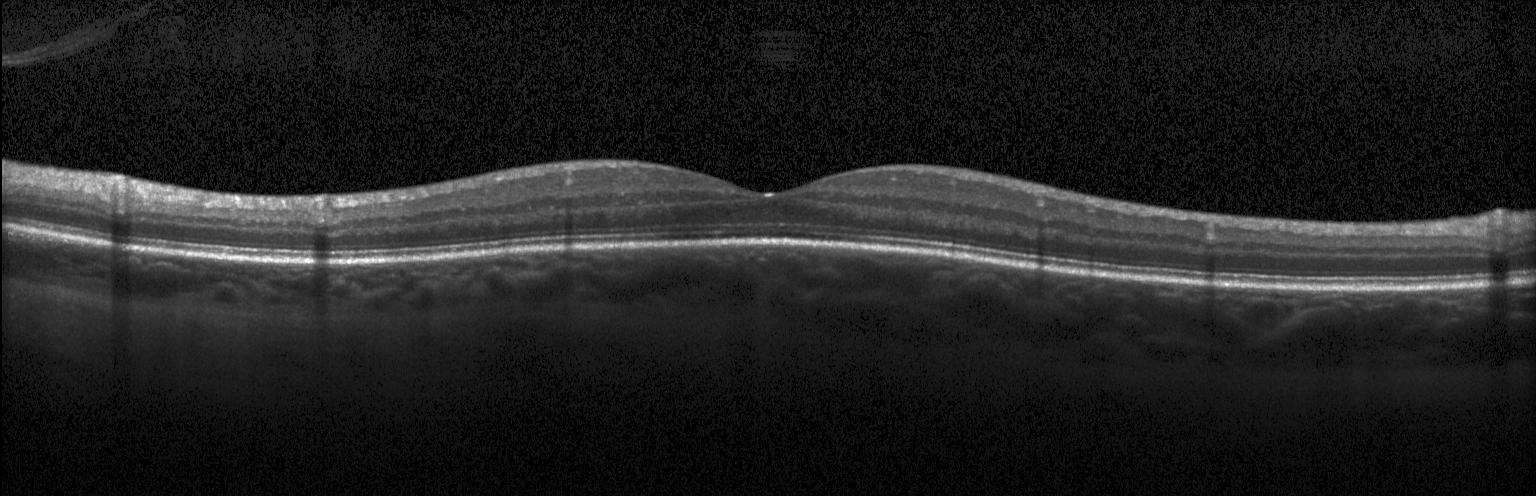

In [10]:
example['image']

In [11]:
dataset["train"].features["label"]

ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7'], id=None)

In [12]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'2'

In [13]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [15]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
#train_ds = dataset['train']

In [16]:
val_ds.shape

(11165, 2)

In [17]:
train_ds.shape

(100482, 2)

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [19]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=768x496>,
 'label': 3,
 'pixel_values': tensor([[[-1.6384, -1.7069, -1.7412,  ..., -1.4672, -1.6384, -1.8439],
          [-1.3987, -1.4672, -1.4672,  ..., -1.5870, -1.5185, -1.3644],
          [-1.4158, -1.8097, -1.8953,  ..., -1.6555, -1.5528, -1.5014],
          ...,
          [-1.6384, -1.5699, -1.6213,  ..., -1.6384, -1.7925, -1.7412],
          [-1.5870, -1.6555, -1.7925,  ..., -1.6727, -1.7754, -1.8097],
          [-1.8097, -1.9980, -1.9467,  ..., -1.7412, -1.7583, -1.7412]],
 
         [[-1.5455, -1.6155, -1.6506,  ..., -1.3704, -1.5455, -1.7556],
          [-1.3004, -1.3704, -1.3704,  ..., -1.4930, -1.4230, -1.2654],
          [-1.3179, -1.7206, -1.8081,  ..., -1.5630, -1.4580, -1.4055],
          ...,
          [-1.5455, -1.4755, -1.5280,  ..., -1.5455, -1.7031, -1.6506],
          [-1.4930, -1.5630, -1.7031,  ..., -1.5805, -1.6856, -1.7206],
          [-1.7206, -1.9132, -1.8606,  ..., -1.6506, -1.6681, -1.6506]],


In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at models/swin_pretrained and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-oct-80-batch-size-with-cosine-restarts-f1",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

In [22]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")

In [23]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [25]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/sagarnildass/anaconda3/envs/artelus/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
0,0.265600,0.163661,0.941640
1,0.221500,0.171723,0.939797
2,0.221500,0.151011,0.947899
4,0.172100,0.218412,0.924625
4,0.167100,0.106147,0.962250
5,0.149700,0.137765,0.953233
6,0.160800,0.127402,0.956832
8,0.165600,0.148883,0.951107
8,0.153500,0.121925,0.957742
9,0.134800,0.121454,0.958226


***** train metrics *****
  epoch                    =          9.99
  total_flos               = 23247704955GF
  train_loss               =        0.2129
  train_runtime            =    7:46:21.66
  train_samples_per_second =         35.91
  train_steps_per_second   =         0.112


In [26]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.99
  eval_f1                 =     0.9623
  eval_loss               =     0.1061
  eval_runtime            = 0:01:16.48
  eval_samples_per_second =    145.972
  eval_steps_per_second   =       1.83


# Testing

In [27]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, AutoImageProcessor

model = AutoModelForImageClassification.from_pretrained(
    "swin_pretrained-finetuned-oct-80-batch-size-with-cosine-restarts-f1", 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
) 

In [28]:
test_data = load_dataset("imagefolder", data_dir=TEST_DATA_PATH)


Resolving data files:   0%|          | 0/1153 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/sagarnildass/.cache/huggingface/datasets/imagefolder/default-d55f3bd96a5422b2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
#test_data

In [30]:
test_ds = test_data["train"]

In [31]:
test_ds.set_transform(preprocess_val)


In [32]:
test_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x496>,
 'label': 0,
 'pixel_values': tensor([[[ 2.2318,  2.2318,  2.2147,  ...,  2.2489,  2.2489,  2.2489],
          [-0.3541, -0.3198, -0.2856,  ...,  2.2489,  2.2489,  2.2489],
          [-1.6898, -1.7240, -1.7583,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-2.1008, -2.1008, -2.0152,  ..., -2.0494, -2.0323, -1.9638],
          [-2.1008, -2.0323, -2.0323,  ..., -2.0323, -1.9809, -1.9638],
          [-2.0494, -1.9980, -2.0323,  ..., -2.0665, -2.0152, -1.9809]],
 
         [[ 2.4111,  2.4111,  2.3936,  ...,  2.4286,  2.4286,  2.4286],
          [-0.2325, -0.1975, -0.1625,  ...,  2.4286,  2.4286,  2.4286],
          [-1.5980, -1.6331, -1.6681,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-2.0182, -2.0182, -1.9307,  ..., -1.9657, -1.9482, -1.8782],
          [-2.0182, -1.9482, -1.9482,  ..., -1.9482, -1.8957, -1.8782],
          [-1.9657, -1.9132, -1.9482,  ..., -1.9832, -1.9307, -1.8957]],

In [33]:
predictions, labels, metrics = trainer.predict(test_ds, metric_key_prefix="predict")

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

In [35]:
final_preds = np.argmax(predictions, axis=1)

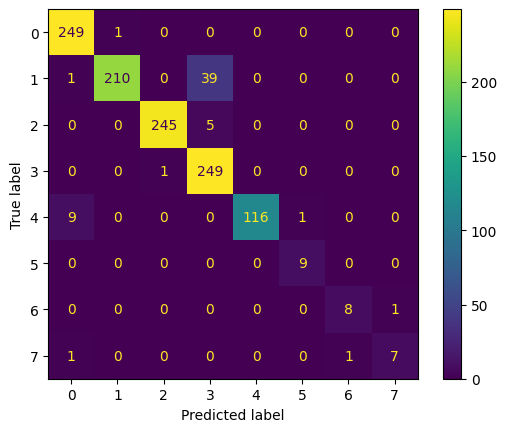

In [36]:
cf_matrix = confusion_matrix(labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                             )
disp.plot()